In [24]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

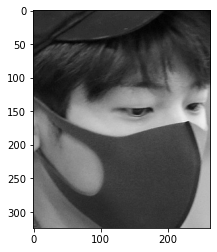

[[ 46  47  43 ...  11  14   8]
 [ 44  46  43 ...  11  14  10]
 [ 42  46  45 ...  12  12  10]
 ...
 [ 78  70  59 ... 178 181 180]
 [ 60  65  67 ... 177 179 179]
 [ 66  79  93 ... 176 178 177]]
./dataset/with_mask


In [40]:
dir_file = "./dataset"
class_category = ['with_mask', 'without_mask']

# %% [code]
for category in class_category:  # do dogs and cats
    path = os.path.join(dir_file,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

print(img_array)
print(path)

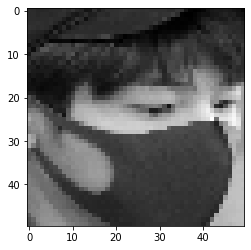

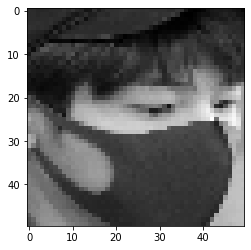

./dataset/with_mask


In [41]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
training_data = []
print(path)

In [43]:
from tqdm import tqdm
def create_training_data():
    for category in class_category:  # do dogs and cats

        path = os.path.join(dir_file,category)  # create path to dogs and cats
        print(path)
        class_num = class_category.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


  0%|          | 2/1938 [00:00<02:17, 14.04it/s]

./dataset/with_mask


  1%|          | 16/1930 [00:00<00:11, 159.76it/s]

./dataset/without_mask


100%|██████████| 1930/1930 [00:14<00:00, 131.20it/s]

3868


In [47]:
import random

random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)



0
0
0
1
0
1
1
1
0
1
[[[[244]
   [238]
   [240]
   ...
   [229]
   [229]
   [179]]

  [[239]
   [247]
   [232]
   ...
   [226]
   [223]
   [215]]

  [[244]
   [238]
   [236]
   ...
   [133]
   [ 86]
   [ 56]]

  ...

  [[ 76]
   [115]
   [161]
   ...
   [ 90]
   [ 94]
   [ 98]]

  [[ 82]
   [143]
   [146]
   ...
   [103]
   [ 96]
   [ 91]]

  [[ 71]
   [108]
   [167]
   ...
   [ 98]
   [ 96]
   [ 93]]]]


In [48]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)


In [49]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)
dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, 
                      y,
                      batch_size=32,
                      epochs=25,
                      validation_split=0.3,
                      callbacks=[tensorboard])

model.save('mask_detection.model')


3-conv-64-nodes-0-dense-1607528599
Epoch 1/25
 1/85 [..............................] - ETA: 0s - loss: 0.6920 - accuracy: 0.4375WARNING:tensorflow:From /home/shivam/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
85/85 [==============================] - 7s 80ms/step - loss: 0.5798 - accuracy: 0.6838 - val_loss: 0.5007 - val_accuracy: 0.7519
Epoch 2/25
85/85 [==============================] - 6s 76ms/step - loss: 0.3968 - accuracy: 0.8234 - val_loss: 0.3610 - val_accuracy: 0.8338
Epoch 3/25
85/85 [==============================] - 6s 76ms/step - loss: 0.3205 - accuracy: 0.8618 - val_loss: 0.3160 - val_accuracy: 0.8570
Epoch 4/25
85/85 [==============================] - 7s 77ms/step - loss: 0.2829 - accuracy: 0.8810 - val_loss: 0.3033 - val_accuracy: 0.8648
Epoch 5/25
85

# PREDICTION

In [51]:
import cv2
import tensorflow as tf

class_category = ["with_mask", "without_mask"]


def prepare(filepath):
    IMG_SIZE = 50  # 50 in txt-based

    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    #new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


model = tf.keras.models.load_model('mask_detection.model')

prediction = model.predict([prepare('./predict/WhatsApp Image 2020-12-09 at 21.19.37.jpeg')])
print(prediction,'\n')  # will be a list in a list.

print(class_category[int(prediction[0][0])])

[[0.]] 

with_mask


In [52]:
import tensorflow as tf
CATS_VS_DOGS_SAVED_MODEL = "maskdetection"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: maskdetection/assets
